# Library and Package installation
- biopython
- scipy 
- matplotlib
- numpy 
conda install <pakage>

In [292]:
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
import numpy as np
import math
import matplotlib
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
from RamachanDraw import phi_psi
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
import os

In [293]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [294]:
# Set path to a fodler for input/output data
# Change here according to your setup
#path = 'drive/My Drive/structural_bioinformatics/Homework1/data'

#import os
#if os.path.exists(path +'/figures') is False:
  #os.mkdir(path +'/figures')

#Parsing 
- id_protein =  1uf5_A Crystal structure of C171A/V236A Mutant of N-carbamyl-D-amino acid amidohydrolase complexed with N-carbamyl-D-methionine


In [295]:
path = "."
id_protein = '1uf5'
#id_protein = '1a3n'
#id_protein = '1ot6'

In [296]:
parser = PDBParser(QUIET=True)
# if the file does not exist, it will be downloaded
if os.path.exists(path + "/pdb/pdb{}.ent".format(id_protein.lower())) is True:
  path_pdb = path + "/pdb/pdb{}.ent".format(id_protein.lower())
else:
  pdbl = PDBList()
  path_pdb = pdbl.retrieve_pdb_file(id_protein, pdir=path + "/pdb", file_format="pdb")
structure = parser.get_structure(id_protein, path_pdb)
new_structure = structure.copy()


In [297]:
class Select(Select):
    def __init__(self, chain_ids=None, residues=None):
        self.chain_ids = chain_ids
        self.residues = residues

    def accept_chain(self, chain):
        return self.chain_ids is None or chain.id in self.chain_ids

    def accept_residue(self, residue):
        #return self.residues is None or residue in self.residues or 
        return ( residue.id[0] == ' ' and residue.resname not in ['HOH', 'H2O', 'DOD', 'WAT', 'ACT', 'ADP', 'ATP', 'GDP', 'GTP', 'UDP', 'UTP', 'HEM'] )

    def accept_atom(self, atom):
        return not atom.is_disordered() or atom.get_altloc() == "A"


In [298]:
pdbl = PDBList()
path_pdb_cleaned = path + "/pdb/pdb{}_cleaned.pdb".format(id_protein.lower())
pdbl.retrieve_pdb_file(id_protein, pdir= path + "/pdb", file_format='pdb')  # Will save a pdbXXXX.ent file

Structure exists: './pdb/pdb1uf5.ent' 


'./pdb/pdb1uf5.ent'

In [299]:
selector=Select()
# Save the new PDB file
io = PDBIO()
io.set_structure(structure)
io.save(path_pdb_cleaned, select=selector)
structure = parser.get_structure(id_protein, path_pdb_cleaned)
print("finished")

finished


# Distance matrix
Structure with id “1abc” Model with id 0 Chain with id “A” Residue with id (” “, 10, “A”)

The Residue id indicates that the residue is not a hetero-residue (or a water) because it has a blank hetero field, that its sequence identifier is 10 and its insertion code “A”.

In [300]:
def get_distance_matrix(residues, seq_sep):
  distances = []
  for residue1 in residues:
    row = []
    #if the residue is not a glycine, use CB atom or CA atom if the second residue is a glycine
    if residue1.has_id("CB") is True:
      for residue2 in residues:
        if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
          if residue2.has_id("CB") is True:
            row.append(abs(residue1["CB"] - residue2["CB"]))
          else:  
            row.append(abs(residue1["CB"] - residue2["CA"]))
        else: 
          row.append(None)
      distances.append(row)
    else:
      for residue2 in residues: 
        if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
          if residue2.has_id("CB") is True:
            row.append(abs(residue1["CA"] - residue2["CB"]))
          else:  
            row.append(abs(residue1["CA"] - residue2["CA"]))
        else: 
          row.append(None)
      distances.append(row)
  return np.array(distances, dtype=float)

In [301]:
distance_matrix = get_distance_matrix(structure[0]['A'], 6)

/tmp/ipykernel_12245/783038360.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap())


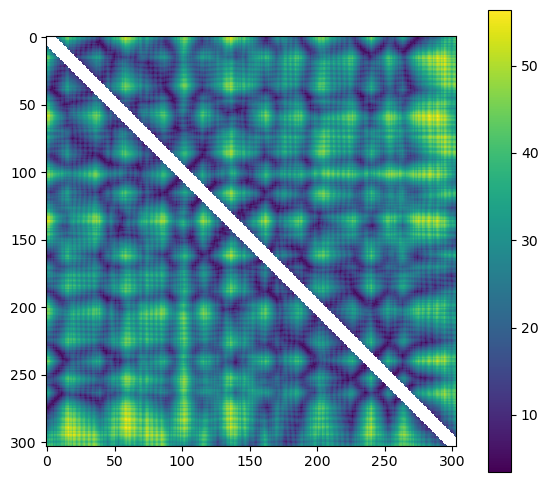

In [302]:
# Alter the color map to highlight 
current_cmap = copy.copy(matplotlib.cm.get_cmap())
current_cmap.set_bad(color='k')

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(distance_matrix)
fig.colorbar(im, fraction=0.05, pad=0.07)
plt.savefig(path + '/figures/ca_distances_{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

246


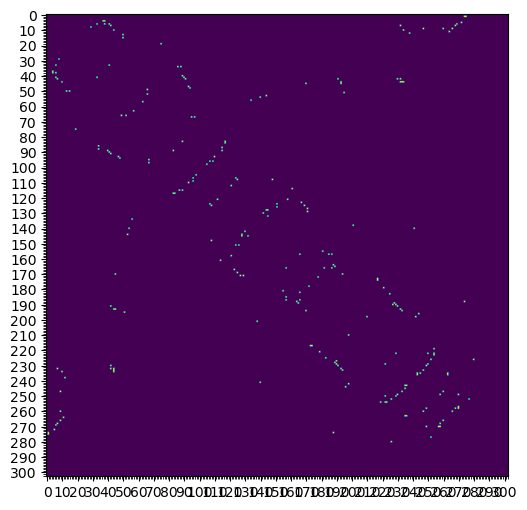

In [303]:
contact_map = (distance_matrix[:] <= 5).astype(float)
#report the number of contacts
print(np.count_nonzero(contact_map)) 
# Plot contact map
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

5858


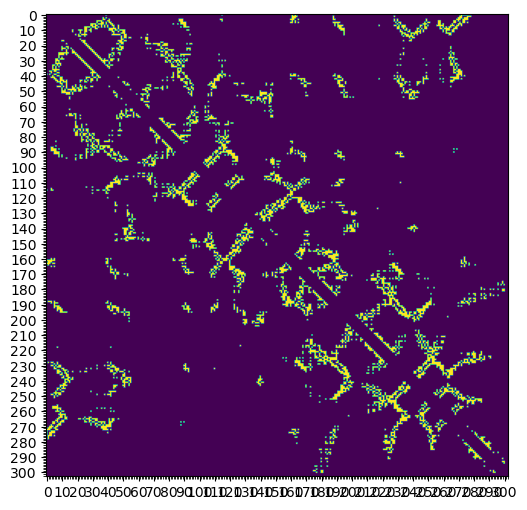

In [304]:
#create a contact map form the distance matrix that only take value between 4 and 7
contact_map = (distance_matrix[:] <= 12).astype(float)
contact_map = (distance_matrix[:] >= 7).astype(float) * contact_map
# Report number of contacts
print(np.count_nonzero(contact_map)) 
# Plot contact map
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}1.png'.format(id_protein), dpi=300, bbox_inches='tight')

34062


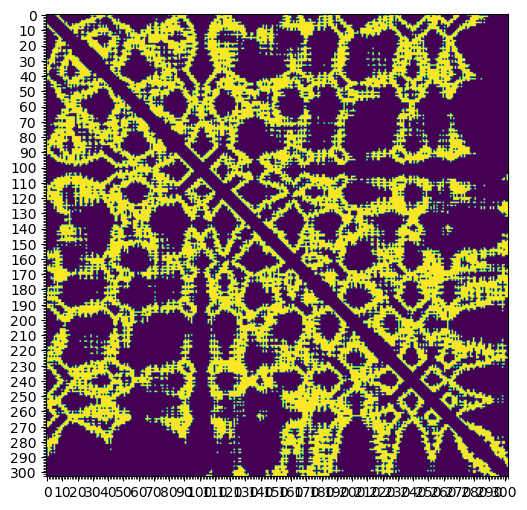

In [305]:
#create a contact map form the distance matrix that only take value between 7 and 12
contact_map = (distance_matrix[:] <= 24).astype(float)
contact_map = (distance_matrix[:] >= 13).astype(float) * contact_map
# Report number of contacts
print(np.count_nonzero(contact_map))
# Plot contact map
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}1.png'.format(id_protein), dpi=300, bbox_inches='tight')

42254


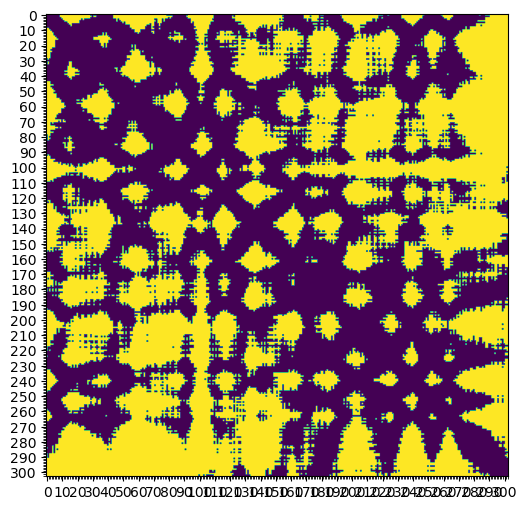

In [306]:
#create a contact map form the distance matrix that only take value between 25 and infinity
contact_map = (distance_matrix[:] >= 25).astype(float)
# Report number of contacts
print(np.count_nonzero(contact_map))
# Plot contact map
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map)
# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures/ca_contacts_{}1.png'.format(id_protein), dpi=300, bbox_inches='tight')

# RamachanDraw

In [307]:
rama = phi_psi(path_pdb_cleaned, return_ignored = True)
print(rama)

             Ignored residues              
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Aminoacid ┃             φ-ψ             ┃
┃ residue   ┃           angles            ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ THR1      │ (None, 0.21640318196626745) │
│ LEU303    │ (-1.3917913927178074, None) │
└───────────┴─────────────────────────────┘

({'THR1': (None, 0.21640318196626745), 'ARG2': (1.007749436066001, 0.8100083737387529), 'GLN3': (-2.048650013796808, 2.750138303819372), 'MET4': (-2.867973127322755, 3.012218918237335), 'ILE5': (-2.109095055891522, 2.060076053820679), 'LEU6': (-1.7144988861145367, 2.476511334125298), 'ALA7': (-2.246516583382141, 2.738039570173352), 'VAL8': (-2.2217886180185835, 2.3127618481543997), 'GLY9': (-1.951457012166089, 1.5696256089190446), 'GLN10': (-1.2546663316106663, 2.4885159502573155), 'GLN11': (-1.8893297206366915, 2.581536495169409), 'GLY12': (-1.5212671319176023, -3.0494771258247706), 'PRO13': (-1.0170537858689441, 2.676880274737662), 'ILE14': (-2.173640508727956, 2.02894822643503), 'ALA15': (-1.2491438038984455, 2.6938184964244494), 'ARG16': (-1.029133252352909, -0.5450510732664436), 'ALA17': (-1.5665499774216631, -0.1684788398517655), 'GLU18': (-1.216444517196804, 2.218747502077465), 'THR19': (-1.3847631625335175, 2.7470219343713405), 'ARG20': (-1.0669032570806922, -0.6077628002516997

In [308]:
# Build the peptides (reveal structure holes) and print sequences
print("Peptides")
ppb = PPBuilder()  # PolyPeptideBuilder
for model in structure:
    for chain in model:
        print(chain.id, len([residue for residue in chain if is_aa(residue)]))
        for pp in ppb.build_peptides(chain):
            print(len(pp), pp.get_sequence())

Peptides
A 303
303 TRQMILAVGQQGPIARAETREQVVVRLLDMLTKAASRGANFIVFPELALTTFFPRWHFTDEAELDSFYETEMPGPVVRPLFEKAAELGIGFNLGYAELVVEGGVKRRFNTSILVDKSGKIVGKYRKIHLPGHKEYEAYRPFQHLEKRYFEPGDLGFPVYDVDAAKMGMFIANDRRWPEAWRVMGLRGAEIICGGYNTPTHNPPVPQHDHLTSFHHLLSMQAGSYQNGAWSAAAGKAGMEENCMLLGHSCIVAPTGEIVALTTTLEDEVITAAVDLDRCRELREHIFNFKQHRQPQHYGLIAEL
B 303
303 TRQMILAVGQQGPIARAETREQVVVRLLDMLTKAASRGANFIVFPELALTTFFPRWHFTDEAELDSFYETEMPGPVVRPLFEKAAELGIGFNLGYAELVVEGGVKRRFNTSILVDKSGKIVGKYRKIHLPGHKEYEAYRPFQHLEKRYFEPGDLGFPVYDVDAAKMGMFIANDRRWPEAWRVMGLRGAEIICGGYNTPTHNPPVPQHDHLTSFHHLLSMQAGSYQNGAWSAAAGKAGMEENCMLLGHSCIVAPTGEIVALTTTLEDEVITAAVDLDRCRELREHIFNFKQHRQPQHYGLIAEL


In [309]:
# Calculate PSI and PHI
rama = {}  # { chain : [[residue_1, ...], [phi_residue_1, ...], [psi_residue_2, ...] ] }
for model in structure:
    for chain in model:
        for pp in ppb.build_peptides(chain):

            phi_psi = pp.get_phi_psi_list()  # [(phi_residue_1, psi_residue_1), ...]
            for i, residue in enumerate(pp):
               # print(model, chain, i, residue, phi_psi[i])

                # Convert radians to degrees and remove first and last value that are None
                if phi_psi[i][0] is not None and phi_psi[i][1] is not None:
                    rama.setdefault(chain.id, [[], [], []])
                    rama[chain.id][0].append(residue)
                    rama[chain.id][1].append(math.degrees(phi_psi[i][0]))
                    rama[chain.id][2].append(math.degrees(phi_psi[i][1]))


outliers for chain = A, number of outliers = 7
outliers for chain = B, number of outliers = 12


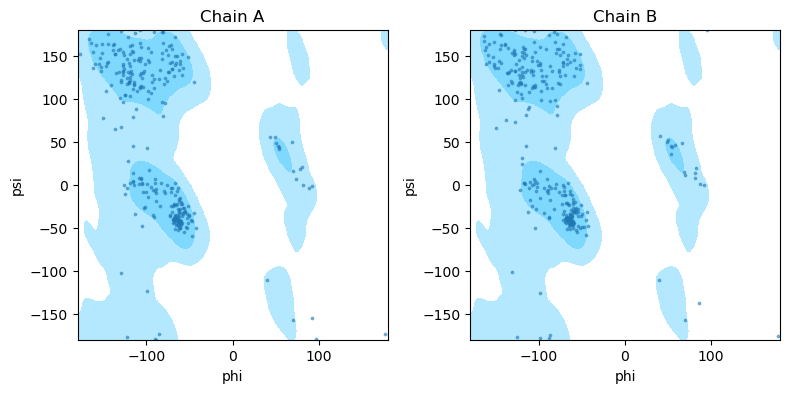

In [312]:
# Ramachandran regions
# 2 = 90%, 1 = 60%
regions_matrix = []
with open(path + "/ramachandran.dat") as f:
    for line in f:
        if line:
            regions_matrix.append([int(ele) for ele in line.strip().split()])

# Plot Ramachandran regions
cmap = mplcolors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF'])
f, axes = plt.subplots(1, len(rama), figsize=(8, 8))
axes = np.array(axes).reshape(-1)  # Hack to give consistency for single/multiple suplots (-1 force reshape to infer dimensions)
for ax, chain_id in zip(axes, rama):
    count = 0
    for phi , psi in zip(rama[chain_id][1], rama[chain_id][2]):
        if regions_matrix[int(phi + 180)][int(psi + 180)] == 1:
            count += 1
    print(f'outliers for chain = {chain_id}, number of outliers = {count}')
    # Plot regions (60 percentile & 90 percentile)
    im = ax.imshow(regions_matrix, cmap=cmap, extent=(-180, 180, -180, 180))

    # Plot points
    ax.scatter(rama[chain_id][1], rama[chain_id][2], s=3, alpha=0.5)

    ax.set_xlabel('phi')
    ax.set_ylabel('psi')
    ax.set_title('Chain {}'.format(chain_id))

plt.tight_layout()  # Remove figure padding
plt.savefig(path +'/figures/ramachandran_regions.png', dpi=300, bbox_inches='tight')